<a href="https://colab.research.google.com/github/gastonbujia/curso-visualizacion-datos-SAN-2022/blob/main/notebooks/SAN_dia_2/solucion/sol_notebook_comportamiento_social_calms21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>
CalMS21: Caltech Mouse Social Interaction Dataset 2021 🐁🐀
</h1>

Esta notebook es una adaptación de la provista por NeuroMatch Academy durante la escuela de [Computational Neuroscience](https://compneuro.neuromatch.io/tutorials/intro.html) curada por Ann Kenedy, que a su vez es una adapatación de la que fuera creada por Dipam Chakraborty y Sharada Mohanty de AIcrowd para el <a href=https://www.aicrowd.com/challenges/multi-agent-behavior-representation-modeling-measurement-and-applications>Multi-Agent Behavior Challenge</a>. La notebook original puede ser encontrada en este [link](https://compneuro.neuromatch.io/projects/behavior/README.html).

Este [dataset](https://data.caltech.edu/records/s0vdx-0k302) tiene estimaciones de pose-tracking de ratones interactuando socialmente mediante capturas de video y además cuenta con anotaciones sobre 3 posibles interacciones sociales: *investigacion*, *montar* y *atacar* separada de *otros* compartamientos.


# Imports e instalaciones 📚


In [1]:
import os
import json
import numpy as np
import pandas as pd

# Algunas librerias para graficar
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Seteamos el estilo
sns.set(style="darkgrid")

# Reducción de la dimensión y otros
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Dataset CalMS21 📲

El dataset **CalMS21** esta hosteado y mantenido por Caltech en https://data.caltech.edu/records/1991. Brevemente, CalMS21 contiene videos y datos anotados de una tarea experimental en la cual se estudia el comportamiento social entre dos ratones, uno que es residente del ambiente y un segundo que es introducido en el mismo. Las interacciones duran aproximadamente unos 10 minutos, son grabadas en un plano cenital y se anotan los comportamientos registrados durante ese tiempo. De los videos se extraen 7 puntos (`keypoints`) para cada ratón estimados por un red neuronal y una confianza de la localización de estos puntos.

![](https://images.aicrowd.com/uploads/ckeditor/pictures/332/content_expt_setup_merged.gif)

Pueden encontrar [acá](https://www.youtube.com/watch?v=tDmhmasjPeM) un video donde una de las autoras del trabajo nos cuenta sobre este dataset.

Dado que el dataset fue construido con el objetivo de probar técnicas de Machine Learning y Deep Learning, hay más de una tarea expermiental, y cada una de ellas contará con un conjunto de *entrenamiento*(`train`) y de *evaluación*(`test`). En esta notebook solo usaremos los datos anotados como la *tarea 1* (`task1`) y el conjunto de entrenamiento. 

In [2]:
# @title Descarga y unzip
import os, requests, zipfile

# Descargamos los datos a colab
fname = 'task1_classic_classification.zip'
url = "https://data.caltech.edu/records/s0vdx-0k302/files/task1_classic_classification.zip?download=1"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
else:
  print('Data have already been downloaded!!!')

if not os.path.exists('task1_classic_classification'):
  # Unzip the file
  with zipfile.ZipFile(fname, 'r') as zip_ref:
    zip_ref.extractall('.')

# Descargamos el parser
fname = 'calms21_convert_to_npy.py'
url = "https://data.caltech.edu/records/s0vdx-0k302/files/calms21_convert_to_npy.py?download=1"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

Los archivos del conjunto de datos se almacenan como archivos json. Para facilitar el manejo, primero los convertiremos a archivos .npy usando el script que acabamos de descargar, `calms21_convert_to_npy.py`. La salida de este script es un par de archivos, `calms21_task1_train.npy` y `calms21_task1_test.npy`. Como nosotros no vamos a intentar hacer predicciones con estos datos sino un análisis exploratorio.

El repositorio cuenta con un script `calms21_convert_to_npy.py` que permite convertir los datos que estan en formato `JSON` a un formato que nos permite leerlo más facilmente: NumPy Array. En la próxima celda mostramos como utilizar el script pasandole los directorios donde se almacenaron los datos descargados. Si se incluye el indicador `parse_treba` opcional, el script creará los archivos `calms21_task1_train_features.npy` y `calms21_task1_test_features.npy`, que contienen unos 60 *features* creadas con <a href=https://openaccess.thecvf.com/content/CVPR2021/html/Sun_Task_Programming_Learning_Data_Efficient_Behavior_Representations_CVPR_2021_paper.html>Task Programming</a>. Mas adelante también exploraremos esta información.



In [3]:
# @title Ejecutar celda para extraer y crear los archivos necesarios
!python calms21_convert_to_npy.py  --input_directory '.' --output_directory '.'
!python calms21_convert_to_npy.py  --input_directory '.' --output_directory '.' --parse_treba

tcmalloc: large alloc 1224941568 bytes == 0x1dee000 @  0x7faf02efe1e7 0x4b2150 0x5ac2ec 0x5dc6af 0x58ee9b 0x5901a3 0x5e3f6b 0x58ee7f 0x5901a3 0x59045e 0x59073e 0x5f3a00 0x4d18aa 0x51b31c 0x5b4a3e 0x58f49e 0x51b221 0x5b41c5 0x58f49e 0x51740e 0x58f2a7 0x51740e 0x5b41c5 0x604133 0x606e06 0x606ecc 0x609aa6 0x64d332 0x64d4de 0x7faf02afbc87 0x5b561a
tcmalloc: large alloc 1224941568 bytes == 0x4ae20000 @  0x7faf02efe1e7 0x4b2150 0x52fcd2 0x52cdd3 0x545a88 0x58ea5d 0x51b4e6 0x5b41c5 0x4ba899 0x4d29f9 0x590d5e 0x591334 0x507cf4 0x5f3a2b 0x4d18aa 0x51b31c 0x5b4a3e 0x58f49e 0x51b221 0x5b41c5 0x58f49e 0x51740e 0x58f2a7 0x51740e 0x5b41c5 0x604133 0x606e06 0x606ecc 0x609aa6 0x64d332 0x64d4de
Saving ./calms21_task1_train
Saving ./calms21_task1_test
tcmalloc: large alloc 1224941568 bytes == 0x3410000 @  0x7f3fb9fed1e7 0x4b2150 0x5ac2ec 0x5dc6af 0x58ee9b 0x5901a3 0x5e3f6b 0x58ee7f 0x5901a3 0x59045e 0x59073e 0x5f3a00 0x4d18aa 0x51b31c 0x5b4a3e 0x58f49e 0x51b221 0x5b41c5 0x58f49e 0x51740e 0x58f2a7 0x5174

# Cargamos la data 💾
A continuación proveemos una función que permite cargar los datos. Si quieren exploren y traten de entender que es lo que hace.

In [4]:
def load_task1_data(data_path, features_path):
  """
  Cargar datos para la tarea 1:
       El vocabulario le dice cómo asignar nombres de comportamiento a identificadores de clase;
       es el mismo para todas las secuencias en este conjunto de datos.
  """
  data_dict = np.load(data_path, allow_pickle=True).item()
  dataset = data_dict['annotator-id_0']
  # Obtener una secuencia y sus llaves.
  sequence_id = list(data_dict['annotator-id_0'].keys())[0]
  vocabulary = data_dict['annotator-id_0'][sequence_id]['metadata']['vocab']
  features = np.load(features_path, allow_pickle=True).item()['annotator-id_0']
  return dataset, features, vocabulary

In [5]:
training_data, training_features, vocab = load_task1_data('./calms21_task1_train.npy', './calms21_task1_train_features.npy')

## Dataset

Las variables recién creadas `training_data` y `test_data` son diccionarios con una clave para cada **Secuencia** en el conjunto de datos, donde una **Secuencia** es un único ensayo residente-intruso, *hay un total de 70 ensayos*. Cada **Secuencia** contiene los siguientes campos:

<ul>
<li><b>keypoints</b>: ubicaciones rastreadas de partes del cuerpo en los dos ratones que interactúan. Estos se producen utilizando una red de reloj de arena apilado entrenada en 15,000 marcos etiquetados a mano.
<ul>
<li>Dimensiones: (n.º de fotogramas) x (ID del ratón) x (coordenada x, y) x (parte del cuerpo).
<li>Unidades: píxeles; las coordenadas son relativas a la imagen completa. Las dimensiones de la imagen original son 1024 x 570.
</ul>
<li><b>scores</b>: estimaciones de confianza para los puntos clave rastreados.
<ul>
<li>Dimensiones: (n.º de fotogramas) x (ID del ratón) x (parte del cuerpo).
<li>Unidades: sin unidades, rango de 0 (confianza más baja) a 1 (confianza más alta).
</ul>
<li> <b>annotations</b>: ID de comportamientos como un número entero anotado en cada cuadro por un experto en el dominio. Consulte a continuación las asignaciones de ID de comportamiento a nombre de comportamiento.
<ul>
<li>Dimensiones: (# cuadros) .
</ul>
<li><b>metadata</b>: los metadatos registrados son annotator_id, que se representa mediante un int, y el vocabulario, que contiene un diccionario que asigna nombres de comportamiento a identificadores enteros en las anotaciones.
</ul>

El archivo 'taskprog_features' contiene el campo adicional:

<ul>
<li><b>features</b>: características precalculadas de un modelo entrenado con programación de tareas en los datos de trayectoria del conjunto de videos sin etiqueta CalMS21.
<ul>
<li>Dimensiones: (n.º de fotogramas) x (dimensión característica = 32).
</li>
</ul>
</ul>

![](https://images.aicrowd.com/uploads/ckeditor/pictures/337/content_keypoints_task_1.png)

<b>NOTA:</b> para todos los puntos clave, el ratón 0 es el ratón residente (negro) y el ratón 1 es el ratón intruso (blanco). Hay 7 partes del cuerpo rastreadas, ordenadas (nose, left ear, right ear, neck, left hip, right hip, tail base).

## ¿Cómo se ven los datos? 🔍

### Resumen de datos

Como se describió anteriormente, nuestro conjunto de datos consta de diccionarios de Secuencias y un vocabulario adjunto que nos dice qué comportamiento es resgistrado con que código numérico:

In [6]:
print("Algunas keys: ", list(training_data.keys())[:3])
print("Vocabulario: ", vocab)
print("Numero de secuencias: ", len(training_data))

Algunas keys:  ['task1/train/mouse001_task1_annotator1', 'task1/train/mouse002_task1_annotator1', 'task1/train/mouse003_task1_annotator1']
Vocabulario:  {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
Numero de secuencias:  70


In [7]:
# Veamos en que formato esta y que tipos tienen para ver si podemos cargarlo facilmente a Pandas
print(f"Tipo de training data: {type(training_data)}")
print(f"Tipo de cada dato de un ensayo: {type(training_data['task1/train/mouse001_task1_annotator1'])}")
sequence_names = list(training_data.keys())
sample_sequence_key = sequence_names[0]
single_sequence = training_data[sample_sequence_key]
print("Nombre de nuestra secuencia: ", sample_sequence_key)
print("Keys de la secuencia: ", single_sequence.keys())
print("Metadata: ", single_sequence['metadata'])
print(f"Numero de frames en una secuencia \"{sample_sequence_key}\": ", len(single_sequence['annotations']))
print(f"Tamaño de los keypoints de una secuencia \"{sample_sequence_key}\": ", single_sequence['keypoints'].shape)

Tipo de training data: <class 'dict'>
Tipo de cada dato de un ensayo: <class 'dict'>
Nombre de nuestra secuencia:  task1/train/mouse001_task1_annotator1
Keys de la secuencia:  dict_keys(['keypoints', 'scores', 'annotations', 'metadata'])
Metadata:  {'annotator-id': 0, 'vocab': {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}}
Numero de frames en una secuencia "task1/train/mouse001_task1_annotator1":  21364
Tamaño de los keypoints de una secuencia "task1/train/mouse001_task1_annotator1":  (21364, 2, 2, 7)


No parece ser tan fácil cargarlo directamente en un DataFrame de Pandas, pero pueden intentarlo en la próxima celda a ver que sucede...

In [8]:
# COMPLETAR pasarlo directamente a dataframe e imprimirlo
df = pd.DataFrame(training_data)
df

,task1/train/mouse001_task1_annotator1,task1/train/mouse002_task1_annotator1,task1/train/mouse003_task1_annotator1,task1/train/mouse004_task1_annotator1,task1/train/mouse005_task1_annotator1,task1/train/mouse006_task1_annotator1,task1/train/mouse007_task1_annotator1,task1/train/mouse008_task1_annotator1,task1/train/mouse009_task1_annotator1,task1/train/mouse010_task1_annotator1,...,task1/train/mouse061_task1_annotator1,task1/train/mouse062_task1_annotator1,task1/train/mouse063_task1_annotator1,task1/train/mouse064_task1_annotator1,task1/train/mouse065_task1_annotator1,task1/train/mouse066_task1_annotator1,task1/train/mouse067_task1_annotator1,task1/train/mouse068_task1_annotator1,task1/train/mouse069_task1_annotator1,task1/train/mouse070_task1_annotator1
keypoints,[[[[831.6592041 805.6592041 775.6592041 780.65...,[[[[214.97402802 183.97402802 139.97402802 148...,[[[[397.97654724 444.97654724 439.97654724 455...,[[[[840.89483643 823.89483643 883.89483643 857...,[[[[608.14988403 557.14988403 561.14988403 540...,[[[[725.06564941 748.06564941 774.06564941 778...,[[[[148.43171387 113.43171387 169.43171387 142...,[[[[461.98978271 408.98978271 464.98978271 432...,[[[[709.38247681 726.38247681 765.38247681 753...,[[[[327.62959595 373.62959595 401.62959595 400...,...,[[[[774.77977905 741.77977905 804.77977905 765...,[[[[366.9783783 303.9783783 346.9783783 313.97...,[[[[858.93834839 807.93834839 795.93834839 789...,[[[[739.05790405 729.05790405 788.05790405 765...,[[[[738.07294922 685.07294922 696.07294922 673...,[[[[269.20490417 225.20490417 224.20490417 212...,[[[[313.98577728 276.98577728 248.98577728 247...,[[[[185.59334564 171.59334564 121.59334564 138...,[[[[607.65760498 643.65760498 663.65760498 653...,[[[[785.31534424 794.31534424 841.31534424 824...
scores,"[[[0.49552804231643677, 0.66752028465271, 0.72...","[[[0.7875715494155884, 0.7696621417999268, 0.8...","[[[0.480934739112854, 0.6976069808006287, 0.48...","[[[0.6032909750938416, 0.4844147562980652, 0.5...","[[[0.39745843410491943, 0.5035790205001831, 0....","[[[0.5327984690666199, 0.4053669571876526, 0.4...","[[[0.49128609895706177, 0.568804919719696, 0.5...","[[[0.45199355483055115, 0.6156253814697266, 0....","[[[0.23436476290225983, 0.12976549565792084, 0...","[[[0.5448248982429504, 0.4935837984085083, 0.5...",...,"[[[0.6645034551620483, 0.5499401092529297, 0.5...","[[[0.6821759939193726, 0.704423725605011, 0.70...","[[[0.4013247489929199, 0.5359834432601929, 0.6...","[[[0.6679304838180542, 0.6781067252159119, 0.6...","[[[0.5025370121002197, 0.7341359853744507, 0.5...","[[[0.37778836488723755, 0.5549989938735962, 0....","[[[0.6915003061294556, 0.6259832382202148, 0.6...","[[[0.7152268290519714, 0.4989011287689209, 0.6...","[[[0.5967026352882385, 0.4186252951622009, 0.3...","[[[0.45764708518981934, 0.1680891215801239, 0...."
annotations,"[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",...,"[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
metadata,"{'annotator-id': 0, 'vocab': {'attack': 0, 'in...","{'annotator-id': 0, 'vocab': {'attack': 0, 'in...","

¿Tiene sentido cargarlo de esta manera? ¿Que representa cada una de las dimensiones de dataframe cargado de esta manera?

# Ejercicio 1: Explorando narices 👃

Hay varias preguntas que nos pueden interesar a la hora de estudiar este conjunto de datos que tiene que ver con describir las posiciones del cuerpo de los ratones según cada comportamiento. Para este ejercicio nos va a interesar explorar que pasa con las narices de los ratones en cada comportamiento para el primer ensayo.

## 1.1 Nos vamos para Pandas! 🐼

a) Como vimos recién vamos a tener que trabajar un poco el dataset para poder cargarlo en Pandas, por eso primero tienen que completar la función de abajo que procesa uno de los ensayos y nos devuelve toda la información en un unico dataframe.

In [9]:
# COMPLETAR esta función para que procese el diccionario de anotaciones en un solo dataframe donde cada columna va a ser una coordenada de un keypoint de cada raton y la confianza
def load_annotator_df(data_dict, annotator):
    
    # vamos a trabajar solo con un ensayo
    dict_aux = data_dict[annotator]
    # vocabulario
    annot_keys = {0:'attack',1: 'investigation',2: 'mount',3:'other'}
    # nombre de los keypoints
    body_parts = ["nose", "left_ear", "right_ear", "neck", "left_hip", "right_hip", "tail_base"]
    # una lista donde iremos dejando cada dataframe para luego unirlos en un unico dataframe
    df_list = []
    
    # desagregamos los keypoints en columnas para cada parte trackeada / aclarar aca que podemos tambien usar una lista por comprension / reemplazar por lista
    df_list.append(pd.DataFrame(dict_aux['keypoints'][:,0,0,:] , dtype=float, columns=['keypoints_mousse_resident_x_'+i for i in body_parts]))
    df_list.append(pd.DataFrame(dict_aux['keypoints'][:,0,1,:] , dtype=float, columns=['keypoints_mousse_resident_y_'+i for i in body_parts]))
    df_list.append(pd.DataFrame(dict_aux['keypoints'][:,1,0,:] , dtype=float, columns=['keypoints_mousse_intruder_x_'+i for i in body_parts]))
    df_list.append(pd.DataFrame(dict_aux['keypoints'][:,1,1,:] , dtype=float, columns=['keypoints_mousse_intruder_y_'+i for i in body_parts]))
    
    # desagregamos la confianza de los keypoints 
    df_list.append(pd.DataFrame(dict_aux['scores'][:,0,:] , dtype=float, columns=['keypoints_mousse_resident_confidence_'+i for i in body_parts]))
    df_list.append(pd.DataFrame(dict_aux['scores'][:,1,:] , dtype=float, columns=['keypoints_mousse_intruder_confidence_'+i for i in body_parts]))

    # COMPLETAR: crear un único dataframe que sea el resultado de concatenar todos los dataframes de la lista df_list que contenga todas las columnas
    df = pd.concat(df_list,axis=1)

    # COMPLETAR: agregar al dataframe recien creado una columna con la etiqueta correspondiente
    df['annotations'] = dict_aux['annotations']

    # COMPLETAR: reemplazar la columna annotations por una que codifique el comportamiento anotado en el vocabulario
    df['annotations'] = df['annotations'].map(annot_keys)
    
    return df

In [10]:
df = load_annotator_df(training_data, 'task1/train/mouse001_task1_annotator1')
df.head()

,keypoints_mousse_resident_x_nose,keypoints_mousse_resident_x_left_ear,keypoints_mousse_resident_x_right_ear,keypoints_mousse_resident_x_neck,keypoints_mousse_resident_x_left_hip,keypoints_mousse_resident_x_right_hip,keypoints_mousse_resident_x_tail_base,keypoints_mousse_resident_y_nose,keypoints_mousse_resident_y_left_ear,keypoints_mousse_resident_y_right_ear,...,keypoints_mousse_resident_confidence_right_hip,keypoints_mousse_resident_confidence_tail_base,keypoints_mousse_intruder_confidence_nose,keypoints_mousse_intruder_confidence_left_ear,keypoints_mousse_intruder_confidence_right_ear,keypoints_mousse_intruder_confidence_neck,keypoints_mousse_intruder_confidence_left_hip,keypoints_mousse_intruder_confidence_right_hip,keypoints_mousse_intruder_confidence_tail_base,annotations
0,831.659204,805.659204,775.659204,780.659204,711.659204,711.659204,643.659204,202.914433,250.914433,189.914433,...,0.778982,0.922279,0.699608,0.751067,0.795224,0.881171,0.719043,0.682353,0.932878,other
1,833.050439,809.050439,778.050439,783.050439,723.050439,717.050439,644.050439,201.895063,251.895063,193.895063,...,0.791372,0.929769,0.682898,0.738210,0.782570,0.863489,0.722852,0.654722,0.932134,investigation
2,838.718976,816.718976,776.718976,787.718976,730.718976,713.718976,646.718976,179.862692,244.862692,193.862692,...,0.705357,0.915428,0.681830,0.694821,0.769179,0.851056,0.744803,0.614182,0.929331,investigation
3,826.757507,815.757507,774.757507,785.757507,743.757507,711.757507,644.757507,175.148063,235.148063,187.148063,...,0.719372,0.928688,0.709577,0.679381,0.732987,0.833839,0.763688,0.627918,0.888559,investigation
4,822.045709,812.045709,768.045709,779.045709,749.045709,709.045709,646.045709,174.457936,222.457936,178.457936,...,0.744179,0.920880,0.722178,0.732408,0.755690,0.865508,0.815947,0.620493,0.829034,investigation


b) ¿Que comportamientos se registraron para este ensayo?

In [11]:
# COMPLETAR Imprimir los valores unicos de la columna annotations
df.annotations.unique()

array(['other', 'investigation', 'mount'], dtype=object)

## 1.2 Nuevas columnas

Vamos a crear algunas columnas a partir del dataframe cargado que nos permitan caracterizar los comportamientos encontrados en este ensayo y nos basaremos en las distancais de las narices!


a) Para esto queremos mirar los frames que esten bien estimados, vamos a quedarnos solo con aquellos que tienen una estimación de la nariz más alta que 0.5. Primero seleccionen y grafiquen la distribución de esa confianza para las narices para ambos ratones con un histograma conjunto (o pueden usar dos). *Hint* Pueden usar el parámetro `alpha` que controla la transparencia de las barras.

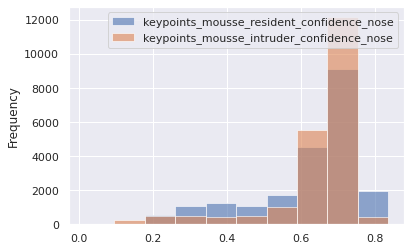

In [12]:
# COMPLETAR: Graficar la distribución de la confianza de los keypoints estimate para la nariz de cada raton
df[["keypoints_mousse_resident_confidence_nose", "keypoints_mousse_intruder_confidence_nose"]].plot(kind='hist',alpha=0.6);

b) Filtren el dataset en base a que ambas columnas sean mayor al corte `thres`. *Hint* Al tener mas de una condición, dependiendo de que quieran hacer las puede servir el comando [`all`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.all.html)

In [13]:
# Crear una mascara con el punto de corte y crear un nuevo dataset a partir de ese
cols = ["keypoints_mousse_resident_confidence_nose", "keypoints_mousse_intruder_confidence_nose"]
thres = 0.5
df_filter = df[(df[cols]>thres).all(axis=1)].copy() # Necesitamos decirle que cree el dataframe nuevo pasandole el parametro copy

# PREGUNTA: Cuantos datos tiraron?
total_frames  = df.shape[0]
total_tirados = total_frames-df_filter.shape[0]
print(f'Descartamos un total del {(total_tirados/total_frames)*100}% de frames')

Descartamos un total del 25.931473506833925% de frames


c) Ahora si podemos pensar en crear la columna que mida la distancia entre las narices de ambos ratones. Para eso podemos calcular la distancia euclídea entre dos puntos de coordenadas $(x_0,y_0)$ y $(x_1,y_1)$ como:

$d=\sqrt{(x_1-x_0)^2+(y_1-y_0)^2}$


Usen las funciones estandar de numpy `sqrt` y `**` para calcularla. PpPpueden usar el atributo `.values` para restar varias columnas entre si. Como adicional vean como pueden calcularla usando la norma del vector restado de las dos narices: [np.linalg.norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html).

In [14]:
# COMPLETAR: Crear una nueva columna que mida la distancia entre las narices de los ratones
df_filter["distance_nose"] = np.sqrt((df_filter["keypoints_mousse_resident_x_nose"]-df_filter["keypoints_mousse_intruder_x_nose"])**2+
                                     (df_filter["keypoints_mousse_resident_y_nose"]-df_filter["keypoints_mousse_intruder_y_nose"])**2)

# Alternativas
resident_nariz = df_filter[["keypoints_mousse_resident_x_nose","keypoints_mousse_resident_y_nose"]].values
intruder_nariz = df_filter[["keypoints_mousse_intruder_x_nose","keypoints_mousse_intruder_y_nose"]].values
# Una manera mas eficiente de hacerlo
aux0 = np.sqrt(((resident_nariz-intruder_nariz)**2).sum(axis=1))
# Con linalg
aux1 = np.linalg.norm(resident_nariz-intruder_nariz, axis=1)

d) Finalmente graficar en un violinplot la distribución de la columna nueva para cada comportamiento registrado.

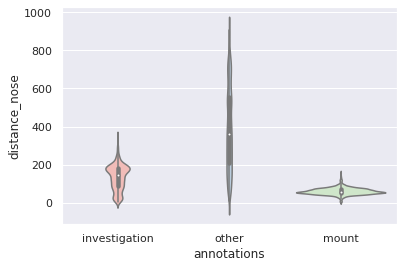

In [15]:
# COMPLETAR: Graficar para cada comportamiento registrado la distribución de estas distancias (usar un violinplot)
sns.violinplot(x="annotations", y="distance_nose", data=df_filter, palette="Pastel1")
plt.show()

## 1.3 Correlaciones de movimiento

Por último podemos ver que sucede con la correlación entre las columnas dependiendo de cada comportamiento. Para eso vamos a seleccionar las columnas asociadas a cada punto del cuerpo en el dataframe filtrado y crear nuevas columnas distancia entre ellos y ver si existe correlaciones entre ellas durante la etiqueta `mount`.

In [16]:
# Vamos a seleccionar las columnas y crear las de distancia 
body_parts    = ["nose", "left_ear", "right_ear", "neck", "left_hip", "right_hip", "tail_base"]
cols_intruder = [f"keypoints_mousse_intruder_{coord}_"+part for coord in ["x","y"] for part in body_parts ] # esto es lo que se conoce como lista por comprehension
cols_resident = [f"keypoints_mousse_resident_{coord}_"+part for coord in ["x","y"] for part in body_parts ]
# Hacemos la diferencia coordenada a coordenada
diff_array    = df_filter[cols_intruder].values-df_filter[cols_resident].values
print(diff_array.shape)

# Diff ahora tiene las diferencias coordenada a coordenada, nos falta recorrer las partes del cuerpo y calcular la norma vectorial para obtener las distnacias
for i, part in enumerate(body_parts): # enumerate nos devuelve una tupla (i, part) donde el i es la enumeración de los objetos que hay dentro de la lista
    df_filter[f"distance_{part}"] = np.linalg.norm(diff_array[:,[i,i+7]],axis=1) # 7 porque las columnas son las 7 partes del cuerpo

(15824, 14)


Completar la siguiente celda para graficar el mapa de calor de las correlaciones:

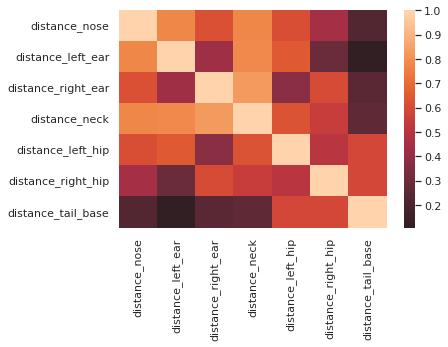

In [17]:
# COMPLETAR
cols     = [f"distance_{part}" for part in body_parts]
corr_mat = df_filter[df_filter["annotations"]=="mount"][cols].corr()

# Plotear un heatmap de las correlaciones
sns.heatmap(corr_mat, 
        xticklabels=corr_mat.columns,
        yticklabels=corr_mat.columns,
        center=0
        );

# (*) Ejercicio 2: Utilizando las features!

Las features constituyen un vector de 60 dimensiones que funcionan como descriptores de cada uno de los frames de los videos de los ratones. Como tienen 60 dimensiones es muy dificil graficar algo, por lo que se hace necesario recurrir a técnicas de [reducción dimensional](https://stackabuse.com/dimensionality-reduction-in-python-with-scikit-learn/). Estas técnicas nos permiten reducir la cantidad de datos preservando caracteristicas de lo datos originales. Para ejempliflicar esto utilizaremos una técnica que se conoce como PCA o [Principal Component Analysis](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html) que busca la direcciones que maximizan la variabilidad de los datos. Veamos un ejemplo.

In [18]:
# Veamos que pasa cuando observamos las features de los frames si nos permiten separar los comportamientos
# Para eso creamos esta función auxiliar que nos devuelve un dataframe con las 60 features mas las anotaciones
def load_annotator_features(feat_dict, annotator):
    
    dict_aux = feat_dict[annotator]
    annot_keys = {0:'attack',1: 'investigation',2: 'mount',3:'other'}
    
    df = pd.DataFrame(dict_aux['features'] , dtype=float)
    df['annotations'] = dict_aux['annotations']
    df['annotations'] = df['annotations'].map(annot_keys)
    
    return df
  
df_features = load_annotator_features(training_features, 'task1/train/mouse001_task1_annotator1')
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,annotations
0,831.659204,805.659204,775.659204,780.659204,711.659204,711.659204,643.659204,202.914433,250.914433,189.914433,...,-1.686340,-0.170703,0.215731,0.251000,0.227394,0.221438,-0.341884,-0.258297,0.247844,other
1,833.050439,809.050439,778.050439,783.050439,723.050439,717.050439,644.050439,201.895063,251.895063,193.895063,...,-1.253083,-0.135972,0.246578,0.284343,0.260936,0.256414,-0.275257,-0.288740,0.288741,investigation
2,838.718976,816.718976,776.718976,787.718976,730.718976,713.718976,646.718976,179.862692,244.862692,193.862692,...,-0.375269,-0.001808,0.268099,0.302942,0.285639,0.274443,-0.085661,-0.299937,0.309663,investigation
3,826.757507,815.757507,774.757507,785.757507,743.757507,711.757507,644.757507,175.148063,235.148063,187.148063,...,0.709808,-0.099615,0.260069,0.291605,0.270890,0.252054,0.117812,-0.249731,0.304101,investigation
4,822.045709,812.045709,768.045709,779.045709,749.045709,709.045709,646.045709,174.457936,222.457936,178.457936,...,1.831389,-0.167013,0.261911,0.262023,0.235552,0.209837,0.161930,-0.224229,0.255363,investigation


In [19]:
# COMPLETAR: seleccionar las columnas correspondientes a los features y guardarla en una variable X como numpy array 
X = df_features.iloc[:,:60].values
print(X.shape)

(21364, 60)


In [20]:
# Para que PCA funcione correctamente debemos estandarizar los datos (media 0, desvio 1) y para eso usaremos una funcion que nos provee Scikit Learn
scaler = StandardScaler()
# Creamos un array nuevo que estará escalado
X_scaled = scaler.fit_transform(X)
# Verifiquemos (ojo que la media puede no dar exactamente 0 pero si un numero muy pequeño)
#print(X_scaled.mean(axis=0))
#print(X_scaled.std(axis=0))

In [21]:
# Estamos listos para reducir la dimension y para eso tenemos que crear nuestro objeto que va a reducir la dimension PCA
# Indicandole el número de dimensiones con el cual nos queremos quedar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Creamos un dataframe
principal_df = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2'])
principal_df['annotations'] = df_features['annotations']
print(principal_df.shape)
principal_df.head()

(21364, 3)


,PC1,PC2,annotations
0,-4.592838,-4.813086,other
1,-5.326409,-4.796462,investigation
2,-5.742800,-4.799456,investigation
3,-5.297018,-4.750459,investigation
4,-4.620037,-4.727178,investigation


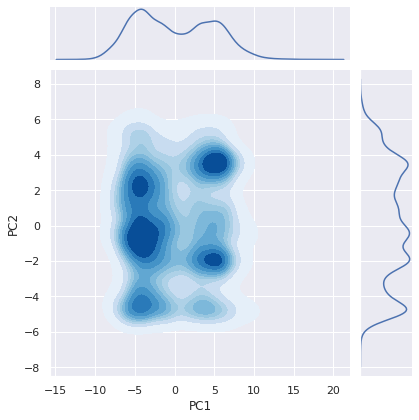

In [22]:
# Grafiquemos que sucede con la distribución espacial de las features - puede tardar un poco
sns.jointplot(x=principal_df.PC1, y=principal_df.PC2, cmap="Blues", shade=True, kind='kde');

a) Graficar un scatterplot de las dos componentes asociadas a cada frame agrupando los datos por anotación. ¿Que conclusiones puede sacar?

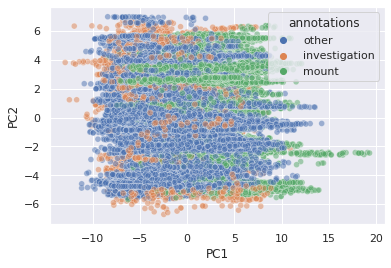

In [23]:
# COMPLETAR
sns.scatterplot( x="PC1", y="PC2", data=principal_df, hue='annotations', legend=True, alpha=0.5);

b) Realizar una reducción a 3 dimensiones a los mismos datos y graficarlos utilizando la función provista por la librería [Plotly](https://plotly.com/python/).

In [24]:
# PCA
pca = PCA(n_components=3)
components = pca.fit_transform(X_scaled)

principal_df = pd.DataFrame(data = components, columns = ['PC1', 'PC2', 'PC3'])
principal_df['annotations'] = df_features['annotations']

# 3D scatterplot interactivo
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=principal_df['annotations'], size=0.1*np.ones(len(X)), opacity = 1,
    title='PCA plot in 3D',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    width=650, height=500
)
fig.show()

¿Ve una mejor separación entre los frames de asociados a cada comportamiento?

# Adicionales: Animaciones de los 🐀

Esta celda contiene algunas funciones auxiliares que usaremos para crear una animación de los movimientos del ratón. Puedne ignorar el contenido, pero asegúrese de ejecutarlo o la siguiente sección no funcionará. Esta parte es solo para ilustrar y motivar todas las cosas que podemos hacer con estos datos y python!

In [28]:
#@title Funciones auxiliares para los gifs y el raster
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import rc
import matplotlib.patches as mpatches

rc('animation', html='jshtml')

# Note: Image processing may be slow if too many frames are animated.

# Plotting constants
FRAME_WIDTH_TOP = 1024
FRAME_HEIGHT_TOP = 570

RESIDENT_COLOR = 'lawngreen'
INTRUDER_COLOR = 'skyblue'

PLOT_MOUSE_START_END = [(0, 1), (0, 2), (1, 3), (2, 3), (3, 4),
                        (3, 5), (4, 6), (5, 6), (1, 2)]
class_to_color = {'other': 'white', 'attack' : 'red', 'mount' : 'green',
                  'investigation': 'orange'}
class_to_number = {s: i for i, s in enumerate(vocab)}
number_to_class = {i: s for i, s in enumerate(vocab)}


def num_to_text(anno_list):
  return np.vectorize(number_to_class.get)(anno_list)


def set_figax():
  fig = plt.figure(figsize=(6, 4))

  img = np.zeros((FRAME_HEIGHT_TOP, FRAME_WIDTH_TOP, 3))

  ax = fig.add_subplot(111)
  ax.imshow(img)

  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  return fig, ax


def plot_mouse(ax, pose, color):
  # Draw each keypoint
  for j in range(7):
    ax.plot(pose[j, 0], pose[j, 1], 'o', color=color, markersize=5)

  # Draw a line for each point pair to form the shape of the mouse

  for pair in PLOT_MOUSE_START_END:
    line_to_plot = pose[pair, :]
    ax.plot(line_to_plot[:, 0], line_to_plot[
            :, 1], color=color, linewidth=1)


def animate_pose_sequence(video_name, keypoint_sequence, start_frame = 0, stop_frame = 100,
                          annotation_sequence = None):
  # Returns the animation of the keypoint sequence between start frame
  # and stop frame. Optionally can display annotations.
  seq = keypoint_sequence.transpose((0,1,3,2))

  image_list = []

  counter = 0
  for j in range(start_frame, stop_frame):
    if counter%20 == 0:
      print("Processing frame ", j)
    fig, ax = set_figax()
    plot_mouse(ax, seq[j, 0, :, :], color=RESIDENT_COLOR)
    plot_mouse(ax, seq[j, 1, :, :], color=INTRUDER_COLOR)

    if annotation_sequence is not None:
      annot = annotation_sequence[j]
      annot = number_to_class[annot]
      plt.text(50, -20, annot, fontsize=16,
               bbox=dict(facecolor=class_to_color[annot], alpha=0.5))

    ax.set_title(
        video_name + '\n frame {:03d}.png'.format(j))

    ax.axis('off')
    fig.tight_layout(pad=0)
    ax.margins(0)

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(),
                                    dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(
        fig.canvas.get_width_height()[::-1] + (3,))

    image_list.append(image_from_plot)

    plt.close()
    counter = counter + 1

  # Plot animation.
  fig = plt.figure()
  plt.axis('off')
  im = plt.imshow(image_list[0])

  def animate(k):
      im.set_array(image_list[k])
      return im,
  ani = animation.FuncAnimation(fig, animate, frames=len(image_list), blit=True)
  return ani


def plot_behavior_raster(annotation_sequence, start_frame=0,
                         stop_frame=100,
                         title="Behavior Labels"):
  # Plot annotations as a behavior raster

  # Map annotations to a number.
  annotation_num = []
  for item in annotation_sequence[start_frame:stop_frame]:
    annotation_num.append(class_to_number[item])

  all_classes = list(set(annotation_sequence[start_frame:stop_frame]))

  cmap = colors.ListedColormap(['red', 'orange', 'green', 'white'])
  bounds=[-0.5, 0.5, 1.5, 2.5, 3.5]
  norm = colors.BoundaryNorm(bounds, cmap.N)

  height = 200
  arr_to_plot = np.repeat(np.array(annotation_num)[:, np.newaxis].transpose(),
                                                  height, axis = 0)

  fig, ax = plt.subplots(figsize = (16, 3))
  ax.imshow(arr_to_plot, interpolation='none',cmap=cmap, norm=norm)

  ax.set_yticks([])
  ax.set_xlabel('Frame Number')
  plt.title(title)

  legend_patches = []
  for item in all_classes:
    legend_patches.append(mpatches.Patch(color=class_to_color[item], label=item))

  plt.legend(handles=legend_patches,loc='center left', bbox_to_anchor=(1, 0.5))

  plt.tight_layout()

## Visualizando los mivimientos 🎥

¡Hagamos algunos gifs de nuestra secuencia de muestra para tener una idea de cómo se ven los datos sin procesar! Puede cambiar los valores de `start_frame` y `stop_frame` para mirar alrededor. Esto va a demorar un poco.

Processing frame  5000
Processing frame  5020
Processing frame  5040
Processing frame  5060
Processing frame  5080


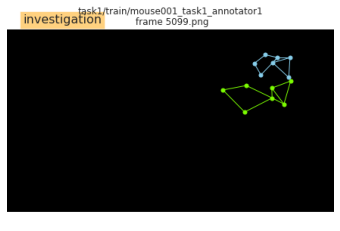

In [29]:
keypoint_sequence = single_sequence['keypoints']
annotation_sequence = single_sequence['annotations']

ani = animate_pose_sequence(sample_sequence_key,
                            keypoint_sequence,
                            start_frame=5000,
                            stop_frame=5100,
                            annotation_sequence=annotation_sequence)

# Display the animation on colab
ani

## Behavior Raster

También podemos ver un **Behavior Raster**, que muestra qué comportamiento se anotó en cada cuadro de este video.

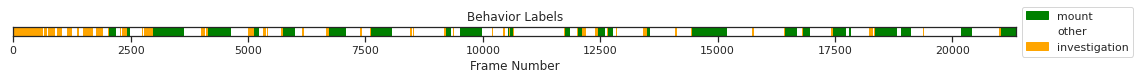

In [33]:
annotation_sequence = single_sequence['annotations']
text_sequence = num_to_text(annotation_sequence)
sns.set(style="ticks")
plot_behavior_raster(
    text_sequence,
    start_frame=0,
    stop_frame=len(annotation_sequence)
    )